# Time Construction Categories

Beginning with their phrase types, I will analyze the kind of time constructions found in the corpus.

In [1]:
from setup_tools import * # get all of the tools for the analyses

This is Text-Fabric 7.8.5
Api reference : https://annotation.github.io/text-fabric/Api/Fabric/

123 features found and 5 ignored
  0.00s loading features ...
   |     0.00s No structure info in otext, the structure part of the T-API cannot be used
  7.29s All features loaded/computed - for details use loadLog()


### Get Timephrases

In [2]:
tp = A.search('''

phrase function=Time
/with/
    word language=Hebrew
/-/
    
''')

XXXX (True, frozenset({'Time'}))
XXXX (True, frozenset({'Time'}))
XXXX (True, frozenset({'Hebrew'}))
  1.07s 3953 results


### Phrase Types Reflected in Constructions

`PP` is prepotional phrase, `NP` is noun phrase, `AdvP` is adverb phrase, as might be expected.

In [3]:
cx_types = collections.Counter()

for cx in F.label.s('timephrase'):
    firstphrase = L.d(cx, 'phrase')[0]
    cx_types[F.typ.v(firstphrase)] += 1
    
cx_types = convert2pandas(cx_types)

cx_types

,Total
PP,2364
NP,890
AdvP,627


In [4]:
cx_types.to_excel(firstyear+'phrase_types.xlsx')

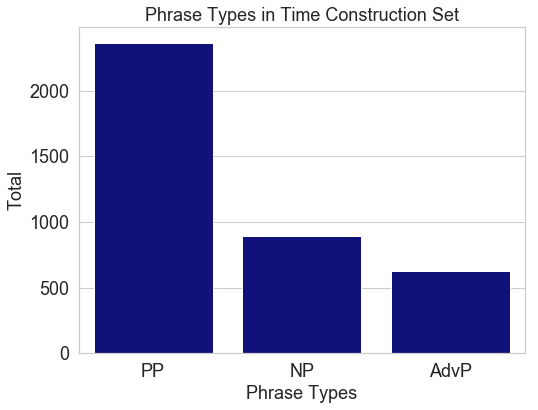

In [5]:
countBarplot(cx_types, title='Phrase Types in Time Construction Set', xlabel='Phrase Types', save=f'{firstyear}phrase_types.png')

Proportion of prepositional phrases...

In [6]:
cx_types.loc['PP']['Total'] / cx_types.sum()[0]

0.6091213604741046

There is a large % difference between the counts of NP and those of PP:

In [7]:
(cx_types.loc['PP']['Total'] - cx_types.loc['NP']['Total']) / cx_types.loc['NP']['Total']

1.6561797752808989

The preposition is the most influential form within time constructions.

### Compare with unprocessed Time Phrases

,Total
PP,2422
NP,901
AdvP,630


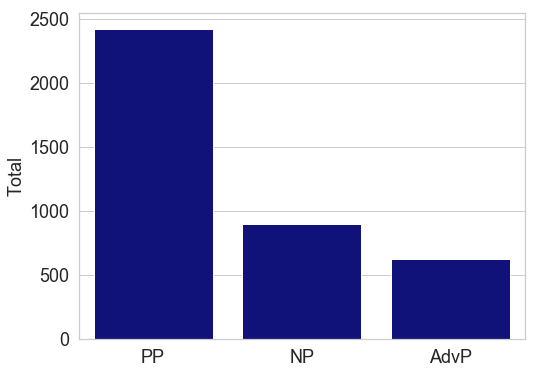

In [8]:
tp_types = collections.Counter()

for ph in tp:
    tp_types[F.typ.v(ph[0])] += 1
    
tp_types = convert2pandas(tp_types)

display(tp_types)

countBarplot(tp_types)

In [9]:
tp_types.loc['AdvP'] - cx_types.loc['AdvP']

Total    3
Name: AdvP, dtype: int64

### Compare with Location

This includes `Loca` phrases as well as complement phrases with a semantic head that has high association with location phrases.

In [10]:
# get words attracted to location
loca_lexs = set(F.lex.v(res[1]) for res in A.search('''

phrase function=Loca
    <nhead- word funct_assoc>2

'''))

locations = []
cmpl2loca = []
locaonly = []


# find location phrases
# if complement phrase, check for a locational lexeme at the head
for phrase in F.otype.s('phrase'):
    
    function = F.function.v(phrase)
    
    # check complement heads for locas
    if function == 'Cmpl' and E.nhead.t(phrase):
        head_lexs = set(F.lex.v(h) for h in E.nhead.t(phrase))
        if head_lexs & loca_lexs:
            locations.append(phrase)
            cmpl2loca.append(phrase)
        
    # log location phrases
    elif function == 'Loca':
        locaonly.append(phrase)
        locations.append(phrase)


print(len(locations), 'total locations found...')
print(len(cmpl2loca), 'complements logged as locas...')
print(len(locaonly), 'default location phrases found...')

XXXX (True, frozenset({'Loca'}))
  0.65s 2243 results
8672 total locations found...
6047 complements logged as locas...
2625 default location phrases found...


,Total
PP,7010
AdvP,1004
NP,467
PrNP\n(proper noun phrase),191


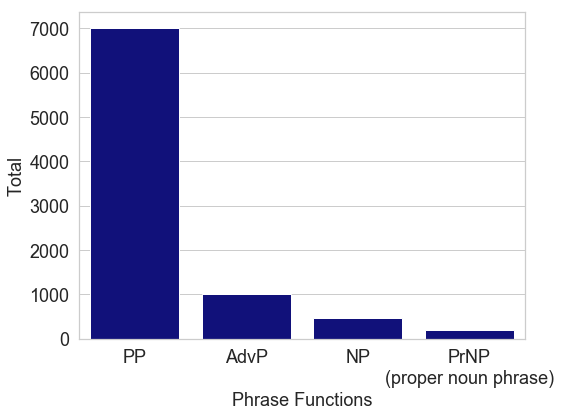

In [11]:
loca_types = collections.Counter()

for ph in locations:
    loca_types[F.typ.v(ph)] += 1
    
loca_types = convert2pandas(loca_types)

loca_types.index = ['PP', 'AdvP', 'NP', 'PrNP\n(proper noun phrase)']

display(loca_types)

countBarplot(loca_types, save=firstyear+'loca_types.png', xlabel='Phrase Functions')

In [12]:
loca_types.to_excel(firstyear+'loca_types.xlsx')

Compare percentage of prepositions...

In [13]:
loca_types.loc['PP'][0]  / loca_types.sum()[0]

0.8083487084870848

### See if Differences Between Loca and Time are Statistically Significant

In [14]:
loca_types

,Total
PP,7010
AdvP,1004
NP,467
PrNP\n(proper noun phrase),191


In [15]:
cx_types

,Total
PP,2364
NP,890
AdvP,627


In [16]:
time_vs_loca = pd.concat([cx_types, loca_types], axis=1, sort=False).fillna(0)
time_vs_loca.columns = ['Time', 'Loca']

time_vs_loca

,Time,Loca
PP,2364.0,7010
NP,890.0,467
AdvP,627.0,1004
PrNP\n(proper noun phrase),0.0,191


Apply Fisher's test for significance...

In [17]:
time_vs_loca_fish = apply_fishers(time_vs_loca)

time_vs_loca_fish

,Time,Loca
AdvP,11.392313,-11.392313
NP,171.481163,-171.481163
PP,-118.354104,118.354104
PrNP\n(proper noun phrase),-30.853584,30.853584


### Preposition & Time Associations

I want to see whether certain prepositions are particularly associated with certain time nouns. A version of this analysis was done [SBH_time_expressions](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/analysis/SBH_time_expressions.ipynb) for Genesis-Kings. Here we do the analysis for the entire Hebrew Bible.

The association measure is the Fisher's exact test.

In [18]:
prep_obj_counts = collections.defaultdict(lambda: collections.Counter())
prep2obj2res = collections.defaultdict(lambda: collections.defaultdict(list))
allpreps = collections.Counter()

for cx in F.label.s('timephrase'):
    
    ph = L.d(cx, 'phrase')[0] # get first phrase
    
    if F.typ.v(ph) != 'PP':
        continue
            
    prep_chunk = next(obj for obj in L.d(cx, 'chunk') if F.label.v(obj) == 'prep') # get prep chunk
    prep_obj = E.obj_prep.t(L.d(prep_chunk, 'word')[-1])
    prep_text = '.'.join(F.lex_utf8.v(w) for w in L.d(prep_chunk, 'word'))
    allpreps[prep_text] += 1
    
    if prep_obj:
        obj_text = F.lex_utf8.v(prep_obj[0])
        prep_obj_counts[prep_text][obj_text] += 1
        prep2obj2res[prep_text][obj_text].append(L.d(cx, 'phrase'))
        
prep_obj_counts = pd.DataFrame(prep_obj_counts).fillna(0)
allpreps = convert2pandas(allpreps)

### Show Preposition Counts

In [19]:
allpreps.to_excel(firstyear+'prep_counts.xlsx')

Count בְּ's share...

In [20]:
allpreps.loc['ב'].sum() / allpreps.sum()[0]

0.538917089678511

In [21]:
search = A.search('''

phrase function=Time typ=PP
    <nhead- word lex=>RK=/

''')

#A.show(search)

XXXX (True, frozenset({'Time'}))
XXXX (True, frozenset({'PP'}))
XXXX (True, frozenset({'>RK=/'}))
  0.65s 2 results


In [22]:
formatPassages(search, api)

'Ps 23:6, 93:5'

### Apply the association test below. This will take some time...

In [23]:
po_assoc = apply_fishers(prep_obj_counts)

#### Attraction Plots

In [24]:
def assign_hue(iterable_data, p=1.3, maxvalue=10, minvalue=-10):
    '''
    Function to assign heat-map hues based 
    on a p-value midpoint and max/min attraction
    values.
    
    The following rules are used for making
    the colors:
    p = pvalue, i.e. significance level
    upper grey = p
    lower grey = -p
    starting red = p+0.1
    starting blue = -p-0.4
    max_red = max(dataset) if > p = hotmax
    max_blue = min(dataset) if < p = coldmax
    
    --output--
    1. a dataframe with values mapped to a unique color code
    2. a list of rgba colors that are aligned with the
       indices of the data
    '''
    
    maxvalue = int(maxvalue) # for max red
    minvalue = int(minvalue) # for max blue
        
    # assign ranges based on p values and red/blue/grey
    red_range = len(range(int(p), maxvalue+1))
    blue_range = len(range(int(p), abs(minvalue-1)))
        
    blues = sns.light_palette('blue', blue_range)
    reds = sns.light_palette('red', red_range)
    grey = sns.color_palette('Greys')[0]
    
    # assign colors based on p-value
    data = list()
    colorCount = collections.Counter()
    rgbs = list()
    for point in iterable_data:
        if point > p:
            rgb = reds[int(point)-1]
            color = 'red'
        elif point < -p:
            rgb = blues[abs(int(point))-1] 
            color = 'blue'
        else:
            rgb = grey
            color = 'grey'
            
        color_count = colorCount.get(color, 0)
        colorCount[color] += 1
        data.append([point, f'{color}{color_count}'])
        rgbs.append(rgb)
        
    data = pd.DataFrame(data, columns=('value', 'color'))
        
    return data, rgbs

In [27]:
# values for uniform hue assignment:
maxattraction = float(po_assoc.max().max())
minattraction = float(po_assoc.min().min())
pvalue = 1.3

def plot_attraction(prep, size=(15, 5), save=''):
        
    # get plot data and generate hues
    colexs = po_assoc[prep].sort_values()    
    colex_data, colors = assign_hue(colexs.values, p=pvalue, maxvalue=maxattraction, minvalue=minattraction)
    
    # plot the figure
    plt.figure(figsize=size)
    dummyY = ['']*colexs.shape[0] # needed due to bug with Y & hue
    ax = sns.swarmplot(x=colex_data['value'], y=dummyY, hue=colex_data['color'], size=15, palette=colors)
    ax.legend_.remove()
        
     # offset annotation text from dot for readability
    offsetX, offsetY = np.array(ax.collections[0].get_offsets()).T
    
    plt.xlabel('log10 Fisher\'s Scores (attraction)')
    
    # annotate lexemes for those with significant values
    for i, colex in enumerate(colexs.index):  
        annotateX = offsetX[i]
        annotateY = offsetY[i] - 0.06
        colex_text = reverse_hb(colex).replace('/','').replace('=','')
        if colexs[colex] > pvalue:
            ax.annotate(colex_text, (annotateX, annotateY), size=20, fontname='Times New Roman')
        elif colexs[colex] < -pvalue:
            ax.annotate(colex_text, (annotateX, annotateY), size=20, fontname='Times New Roman')
            
    if save:
        plt.savefig(f'{firstyear}{prep}_assocs.png', dpi=300, bbox_inches='tight')
    
    plt.title(f'Time Attractions to {reverse_hb(prep)}')
    plt.show()

Let's look at everything up to כ by setting a count limit of > 20.

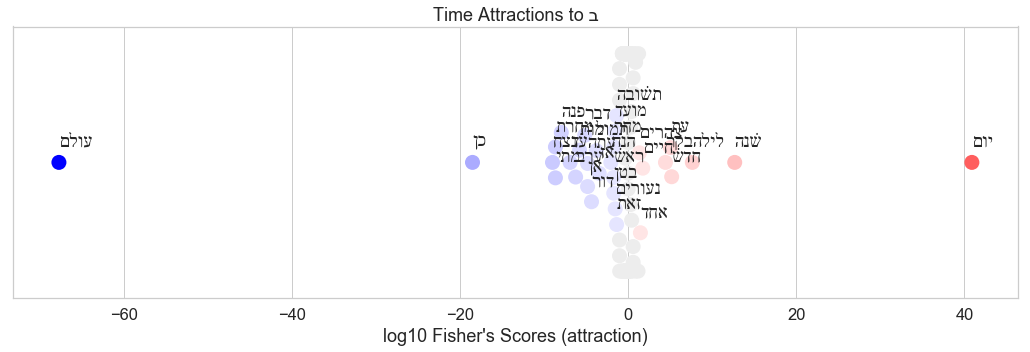

,Fisher's Score,Raw Counts
יום,40.888658,670.0
שׁנה,12.673783,146.0
לילה,7.631617,47.0
חדשׁ,5.174284,46.0
עת,5.035176,116.0
בקר,4.434386,93.0
חיים,1.736167,7.0
אחד,1.454223,6.0
צהרים,1.333080,11.0
ראשׁון,1.241824,14.0


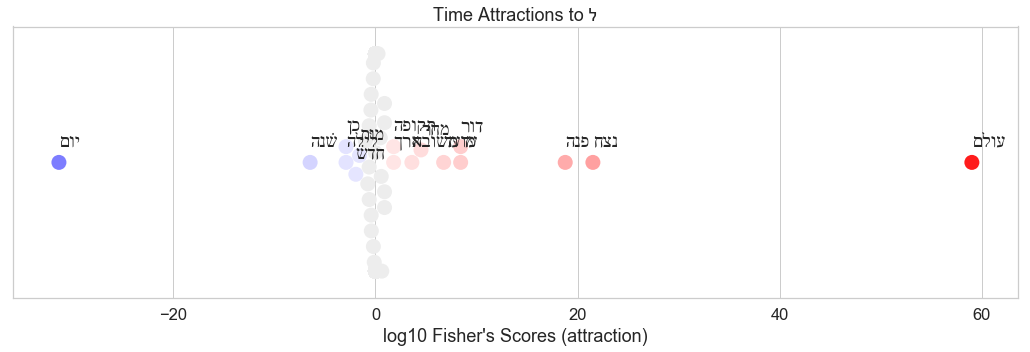

,Fisher's Score,Raw Counts
עולם,59.016055,111.0
נצח,21.516485,25.0
פנה,18.779176,22.0
דור,8.431581,14.0
עד,8.431581,14.0
מועד,6.747924,10.0
מחר,4.508958,5.0
תשׁובה,3.604560,4.0
תקופה,1.799683,2.0
ארך,1.799683,2.0


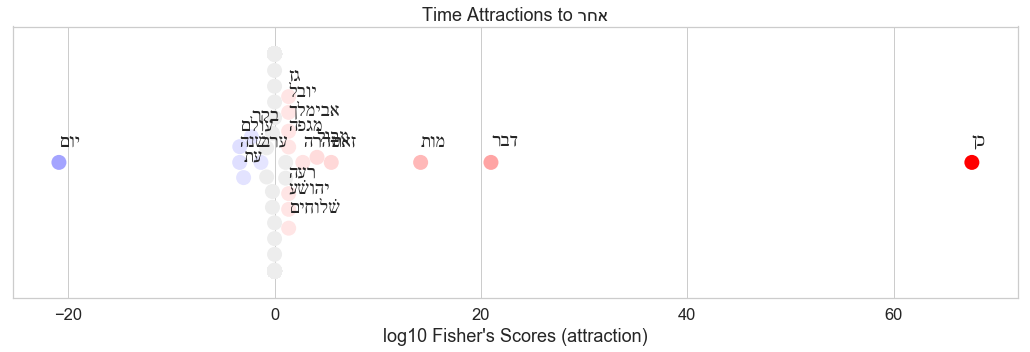

,Fisher's Score,Raw Counts
כן,67.581460,49.0
דבר,20.973330,15.0
מות,14.157562,16.0
זאת,5.495418,4.0
מבול,4.115206,3.0
טהרה,2.739263,2.0
גז,1.367542,1.0
שׁלוחים,1.367542,1.0
יובל,1.367542,1.0
יהושׁע,1.367542,1.0


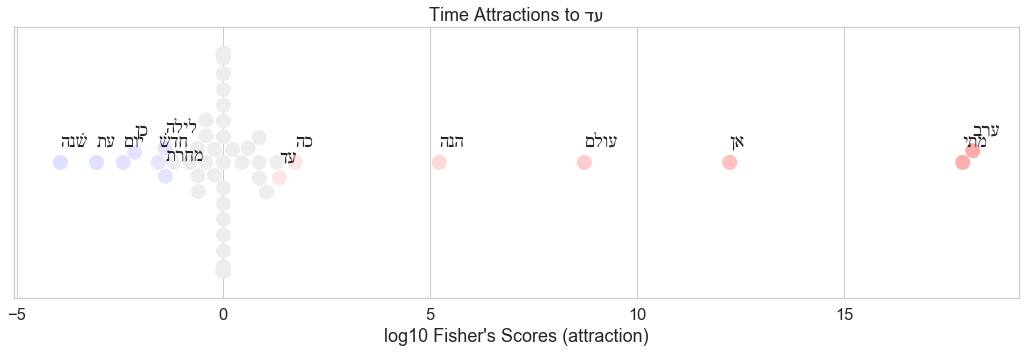

,Fisher's Score,Raw Counts
ערב,18.115809,44.0
מתי,17.872913,23.0
אן,12.240255,14.0
עולם,8.722574,55.0
הנה,5.216771,6.0
כה,1.734152,2.0
עד,1.355419,6.0
מה,1.298069,2.0
אור,1.037558,2.0
כון,0.866483,1.0


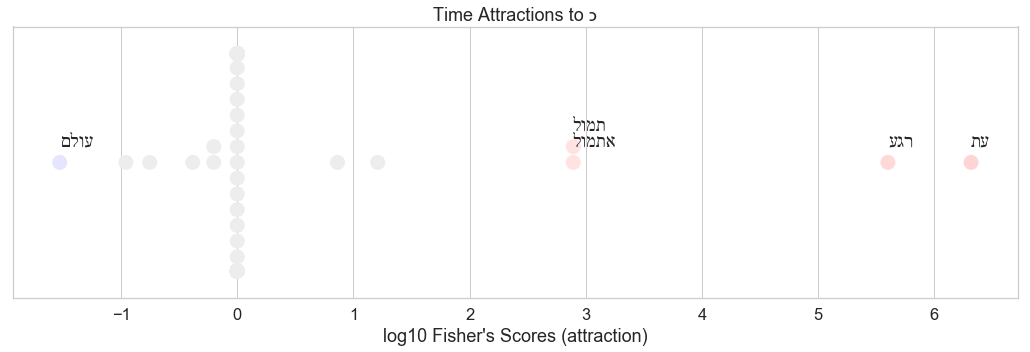

,Fisher's Score,Raw Counts
עת,6.316007,15.0
רגע,5.600207,4.0
תמול,2.892800,3.0
אתמול,2.892222,2.0
מה,1.209204,1.0
מות,0.863121,2.0
ירח,0.000000,0.0
חציר,0.000000,0.0
חרישׁ,0.000000,0.0
חשׁך,0.000000,0.0


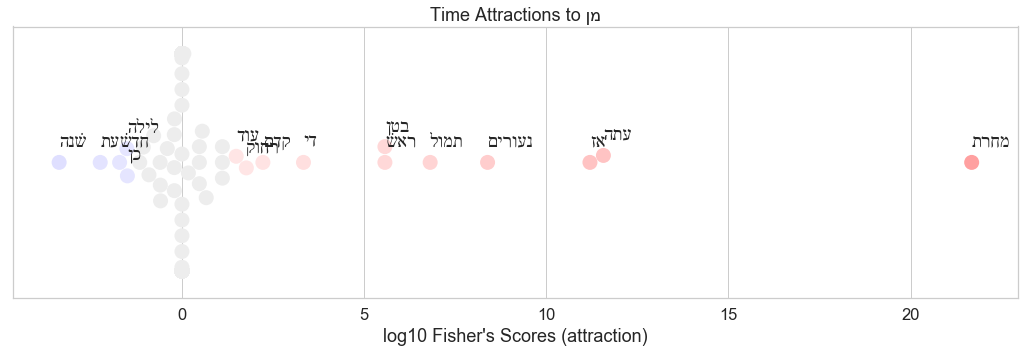

,Fisher's Score,Raw Counts
מחרת,21.678517,22.0
עתה,11.569320,12.0
אז,11.200155,10.0
נעורים,8.389375,9.0
תמול,6.813523,8.0
בטן,5.571650,5.0
ראשׁ,5.571650,5.0
די,3.336264,3.0
קדם,2.221947,2.0
רחוק,1.767669,2.0


In [28]:
for prep in prep_obj_counts.columns[(prep_obj_counts.sum() > 20)]:
    
    top_attractions = pd.DataFrame(po_assoc[prep].sort_values(ascending=False))
    top_attractions.columns = ['Fisher\'s Score']
    top_attractions['Raw Counts'] = prep_obj_counts[prep].loc[top_attractions.index]
    top_attractions.round(2).to_excel(firstyear+f'{prep}_top_assocs.xlsx')
    
    plot_attraction(prep, size=(18, 5), save=True)
    display(top_attractions.head(10))

Look at ממחרת...

In [29]:
min_mxrt = A.search('''

verse
    clause
        phrase function=Time
            <head- word lex=MN
            <obj_prep- word lex=MXRT/

''')

'; '.join(['{} {}:{}'.format(*T.sectionFromNode(res[0])) for res in min_mxrt if F.txt.v(res[1]) in {'N', '?N'}])

XXXX (True, frozenset({'Time'}))
XXXX (True, frozenset({'MN'}))
XXXX (True, frozenset({'MXRT/'}))
  1.06s 24 results


'Genesis 19:34; Exodus 9:6; Exodus 18:13; Exodus 32:6; Exodus 32:30; Numbers 17:6; Numbers 17:23; Joshua 5:11; Joshua 5:12; Judges 6:38; Judges 9:42; Judges 21:4; 1_Samuel 5:3; 1_Samuel 5:4; 1_Samuel 11:11; 1_Samuel 18:10; 1_Samuel 20:27; 1_Samuel 31:8; 2_Samuel 11:12; 2_Kings 8:15; Jeremiah 20:3; 1_Chronicles 10:8'

In [30]:
'; '.join(['{} {}:{}'.format(*T.sectionFromNode(res[0])) for res in min_mxrt if F.txt.v(res[1]) not in {'N', '?N'}])

'Leviticus 19:6; Leviticus 23:11'

Compare with מתמול

In [31]:
min_tmwl = A.search('''

verse
    clause
        phrase function=Time
            <head- word lex=MN
            <obj_prep- word lex=TMWL/

''')

'; '.join(['{} {}:{}'.format(*T.sectionFromNode(res[0])) for res in min_tmwl])

XXXX (True, frozenset({'Time'}))
XXXX (True, frozenset({'MN'}))
XXXX (True, frozenset({'TMWL/'}))
  1.15s 8 results


'Exodus 4:10; Exodus 21:29; Exodus 21:36; Deuteronomy 4:42; Deuteronomy 19:4; Deuteronomy 19:6; Joshua 3:4; Joshua 20:5'

In [32]:
T.text(min_tmwl[0][0])

'וַיֹּ֨אמֶר מֹשֶׁ֣ה אֶל־יְהוָה֮ בִּ֣י אֲדֹנָי֒ לֹא֩ אִ֨ישׁ דְּבָרִ֜ים אָנֹ֗כִי גַּ֤ם מִתְּמֹול֙ גַּ֣ם מִשִּׁלְשֹׁ֔ם גַּ֛ם מֵאָ֥ז דַּבֶּרְךָ אֶל־עַבְדֶּ֑ךָ כִּ֧י כְבַד־פֶּ֛ה וּכְבַ֥ד לָשֹׁ֖ון אָנֹֽכִי׃ '

In [33]:
A.show(A.search('''

phrase function=Time
    <head- word lex=MN
    <obj_prep- word lex=RXM/

'''))

XXXX (True, frozenset({'Time'}))
XXXX (True, frozenset({'MN'}))
XXXX (True, frozenset({'RXM/'}))
  1.13s 1 result


I can see that times which are attracted to ב are primarily calendrical times like "day", "year", "month", "morning", but also עת "time". The attraction between יום and ב is quite strong.

The ל preposition, as well as עד, prefers more deictic, adverbial kinds of indicators like לעולם, לצח, לפני, מחר. Indeed עד has nearly identical preferences. The association between ל and עולם is the strongest in the dataset:

In [34]:
print('top 5 association scores in dataset by their prep')
po_assoc.max().sort_values(ascending=False).head(5)

top 5 association scores in dataset by their prep


אחר    67.581460
ל      59.016055
ב      40.888658
מן     21.678517
עד     18.115809
dtype: float64

In [35]:
print('top 5 associations to ל')
po_assoc['ל'].sort_values(ascending=False).head(5)

top 5 associations to ל


עולם    59.016055
נצח     21.516485
פנה     18.779176
דור      8.431581
עד       8.431581
Name: ל, dtype: float64

This very strong score suggests the possibility that ל and עולם together constitute a strongly entrenched unit. Note also that the association between ל and נצח is likewise quite strong, as is the association with פנה. These smaller associations can be interpreted through the entrenched combination of ל+עולם.  

The preposition אחר has a distinct preference for nouns that are not necessary associated with time, such as proper names and nouns representing events. 

כ is attracted to עת, which is a notable similarity with ב. This is consistent with observations that these two prepositions have similar meanings. The use with תמול and אתמול are worth investigating. 

Finally, מן is primarily attracted to מחרת, a 

### Time Constructions, Raw Forms (without accents)

In [36]:
letter_inventory = set(l for w in F.otype.s('word') for l in F.voc_lex_utf8.v(w))

raw_surfaces = collections.Counter()

for cx in F.label.s('timephrase'):
    surface = ''
    for w in L.d(cx, 'word'):
        for let in F.g_word_utf8.v(w):
            if let in letter_inventory:
                surface += let
        if F.trailer_utf8.v(w) in letter_inventory:
            surface += F.trailer_utf8.v(w)
    raw_surfaces[surface] += 1
        
raw_surfaces = convert2pandas(raw_surfaces)

raw_surfaces.head(20)

,Total
עַתָּה,325
בַּיֹּום הַהוּא,169
הַיֹּום,165
בְּיֹום,64
אָז,64
לְעֹולָם,57
שִׁבְעַת יָמִים,44
בַּבֹּקֶר,42
עַד הַיֹּום הַזֶּה,41
אַחֲרֵי־כֵן,40


In [37]:
raw_surfaces.head(20).to_excel(firstyear+'raw_surfaces.xlsx')

### Time Constructions, Clustered on Raw Surface Forms without Vocalization (tokens)

In this section, I break down time constructions by clustering them based on surface forms and various surface form filters. This is a rough form of clustering, by which two time constructions are grouped together if their tokenized strings match.

In [43]:
def surfaceToken(phrasenode):
    '''
    Return a surface token of a phrase node.
    The words are dot-separated and heh consonants
    are added if they are present in vocalized form. 
    '''
    subtokens = []
    for w in L.d(phrasenode, 'word'):
        if F.lex.v(w) == 'H':
            subtokens.append('ה')
        else:
            subtokens.append(F.g_cons_utf8.v(w))
    return '.'.join(subtokens)
    

freq_surface = collections.Counter()
for cx in F.label.s('timephrase'):
    freq_surface[surfaceToken(cx)] += 1
freq_surface = convert2pandas(freq_surface)

In [44]:
freq_surface.head(20)

,Total
עתה,342
ב.ה.יום.ה.הוא,203
ה.יום,191
ל.עולם,85
ב.ה.בקר,78
עד.ה.יום.ה.זה,71
ב.יום,69
אז,66
שׁבעת.ימים,63
עד.עולם,53


In [45]:
freq_surface.to_excel(firstyear+'raw_tokens.xlsx')

In [46]:
freq_surface.head(50).sum()[0]

2118

In [49]:
freq_surface.head(50).sum()[0] / len(list(F.label.s('timephrase')))

0.545735635145581

ב.ה.יום.ה.הוא is a dominant pattern. But there are other patterns that are similar to it, such as עד.ה.יום.ה.זה or ב.ה.עת.ה.היא. Other similarities include ל.ֹעולם and עד.עולם. Taking a broader definition of similarity to include a role within the phrase, we can see similarities between the preposition + object constructions such as: ל.עולם, ב.יום, ל.נצח.

In [50]:
cases = '''
ב.ה.יום.ה.הוא
עד.ה.יום.ה.זה
ב.ה.עת.ה.היא
ב.ה.ימים.ה.הם
ב.ה.עת.ה.הוא 
ב.ה.לילה.ה.הוא 
ב.עצם.ה.יום.ה.זה 
'''.split('\n')
demos = [c.strip() for c in cases if c]

freq_surface.loc[demos].sum()[0]

383

In [52]:
freq_surface.loc[demos].sum()[0] / len(list(F.label.s('timephrase')))

0.09868590569440866

In [53]:
defi = '''
ה.יום
ב.ה.בקר
עד.ה.ערב
ה.לילה
ב.ה.ערב
ב.ה.לילה'''.split('\n')

defis = [c.strip() for c in defi if c]

freq_surface.loc[defis].sum()[0]

367

In [54]:
freq_surface.loc[defis].sum()[0] / len(list(F.label.s('timephrase')))

0.09456325689255346

### Count Semantic Head Lexemes

In [55]:
sem_heads = collections.Counter()

for cx in F.label.s('timephrase'):
    
    firstphrase = L.d(cx, 'phrase')[0]
    semhead = E.nhead.t(firstphrase)[0]
    
    sem_heads[F.voc_lex_utf8.v(semhead)] += 1
    
sem_heads = convert2pandas(sem_heads)

sem_heads.head(25)

,Total
יֹום,1529
שָׁנָה,376
עַתָּה,364
עֹולָם,197
עֵת,165
לַיְלָה,139
בֹּקֶר,133
עֶרֶב,82
חֹדֶשׁ,79
אָז,77


In [56]:
sem_heads.head(50).to_excel(firstyear+'semantic_heads.xlsx')

Headed by מלכות

In [57]:
# A.show(A.search('''

# construction
#     =: phrase
#     /with/
#     <nhead- word lex=MLKWT/
#     /-/

# '''))

Headed by ראשׁ

In [59]:
A.show(A.search('''

chunk label=timephrase
    =: phrase
    /with/
    <nhead- word lex=<WD/
    /-/

'''))

XXXX (True, frozenset({'timephrase'}))
XXXX (True, frozenset({'<WD/'}))
  0.46s 4 results


### Time Constructions, Clustered on Parts of Speech and Chunks

Based on the kinds of resemblances mentioned above, I wanted to obtain a clustering that better reflected word types and sub-constructions within the time constructions. A "sub-construction", what I have called "chunks", consist of either chained prepositional phrases: e.g. מקץ "from the end of...", or quantified noun phrases, which can consist of chained cardinal numbers such as שׁבעים ושׁשׁ שׁנה. These chunks were processed in [chunking](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/analysis/preprocessing/chunking.ipynb) and then further refined into complete tags in [time constructions [part 1]](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/analysis/time_constructions1.ipynb).

The result is a tokenization strategy which produces larger, more useful clusters. In fact, the top 11 of these clusters account for 76% of the entire dataset, as I show.

In [64]:
freq_times = collections.Counter()
for cx in F.label.s('timephrase'):
    time = Time(cx, api)
    freq_times[time.tag] += 1
    
freq_times = convert2pandas(freq_times)

In [65]:
freq_times.head(20)

,Total
time,653
PPtime,459
PPtime.H.attr_patt.demon,397
PPtime.H,316
PPtime.construct.cons+NP,264
time.H,224
PPtime.H.attr_patt.ord.adjv,183
time.pl.quant.card,180
time.quant.card,125
PPtime.construct.cons+VC,99


Top 11 account for a large % of the dataset:

In [66]:
freq_times.head(11)['Total'].sum() / freq_times['Total'].sum()

0.7691316670961093

The top 20 account accounts for even more:

In [67]:
freq_times.head(20)['Total'].sum() / freq_times['Total'].sum()

0.8729708837928369

It is my hunch that the remaining 25% / 17% of the data most often consists of some combination of the major types reflected in the top 75% group. Thus by describing and understanding these major types, we can obtain even better clustering parameters.

From this point forward I will focus on accounting for the subgroups found amongst these major clusters.

## `prep.time`

What kind of time nouns most often appear in the `time` slot?

In [2]:
pt_time = collections.Counter()
pt_prep = collections.Counter()
pt_cx = collections.Counter()

tag2res = collections.defaultdict(list)

for cx in F.label.s('timephrase'):
    
    time_dat = Time(cx, api)
    
    # skip non prep.time cxs
    if time_dat.tag != 'PPtime':
        continue
            
    time = time_dat.times[0]
    prep = time_dat.preps[0]
    
    time_text = F.lex_utf8.v(time)
    prep_text = '.'.join(F.lex_utf8.v(w) for w in L.d(prep, 'word'))
    cx_text = '.'.join(F.g_cons_utf8.v(w) for w in L.d(cx, 'word'))
    
    pt_time[time_text] += 1
    pt_prep[prep_text] += 1
    pt_cx[cx_text] += 1
    tag2res[cx_text].append(L.d(cx, 'phrase'))
    tag2res[time_text].append(L.d(cx, 'phrase'))
    tag2res[prep_text].append(L.d(cx, 'phrase'))
    
pt_time = convert2pandas(pt_time)
pt_prep = convert2pandas(pt_prep)
pt_cx = convert2pandas(pt_cx)

#### Top Raw Surface Form Counts

In [3]:
pt_cx.head(20)

,Total
ל.עולם,85
עד.עולם,53
אחרי.כן,47
ל.נצח,24
עד.מתי,23
מ.מחרת,19
ל.עלם,15
עד.אנה,13
ל.עד,12
עד.בקר,11


#### Top Times

In [4]:
pt_time.head(20)

,Total
עולם,176
כן,53
נצח,25
מתי,25
עד,20
מחרת,19
אן,14
עתה,14
דור,14
בקר,12


#### Top Preposition Counts

In [5]:
pt_prep

,Total
ל,166
עד,129
מן,75
אחר,54
ב,18
כ,3
מן.אחר,3
ל.מן,3
ל.פנה,2
ב.עוד,2


Does עולם ever have additional modifications? I know from previous analysis of time constructions that they often have various morphological modifications or additional specifications. I would expect this to be different with עולם, and I would also expect this situation to resemble other words that are being used adverbially. If there is indeed a strict separation between patterns with and without these kinds of modifications, I may have good reason to define this as an "adverb construction," i.e. a construction with deictic sense and that caries its temporal modifications internally. 

Practically it makes more sense to first define what I mean, especially in terms of database querying, of "modifications." In order to do that, I move on to the next most common item in the list, יום. I know from the previous analysis that יום *does* in fact attract these modifications. By definining them here, I might have a way to identify other cases that have such modifications. Then I can define those without modifications as the inverse of these search parameters.

**Below are a few examples of יום as used with a preposition.** The examples are shown in the context of a sentence, because infinitival modifiers of יום will exist occur as clauses embedded in the same sentence. These cases in particular are marked with a clause relation of `RgRc` (Regens/rectum connection). Note that I have collapsed the cases with `end=1`. Modify this to see all the other examples. 

In [6]:
A.show(tag2res['יום'], condenseType='sentence', extraFeatures='st vt', end=1) # <- NB modify end= to see more than 5 examples

In [7]:
random.shuffle(tag2res['יום'])

In [8]:
jwm = tag2res['יום']

for ph in jwm[:5]:
    print('{} {}:{}'.format(*T.sectionFromNode(ph[0])))
    print(T.text(L.u(ph[0], 'sentence')[0]))
    print()

Isaiah 43:13
גַּם־מִיֹּום֙ אֲנִ֣י ה֔וּא 

1_Samuel 18:10
וְדָוִ֛ד מְנַגֵּ֥ן בְּיָדֹ֖ו כְּיֹ֣ום׀ בְּיֹ֑ום 

2_Chronicles 24:11
כֹּ֤ה עָשׂוּ֙ לְיֹ֣ום׀ בְּיֹ֔ום 

Ezekiel 48:35
וְשֵׁם־הָעִ֥יר מִיֹּ֖ום יְהוָ֥ה׀ שָֽׁמָּה׃ 

1_Chronicles 16:23
בְּנֵ֥י יַעֲקֹ֖ב בְּחִירָֽיו׃ זִכְר֤וּ לְעֹולָם֙ בְּרִיתֹ֔ו דָּבָ֥ר צִוָּ֖ה לְאֶ֥לֶף דֹּֽור׃ אֲשֶׁ֤ר כָּרַת֙ אֶת־אַבְרָהָ֔ם וּשְׁבוּעָתֹ֖ו לְיִצְחָֽק׃ שִׁ֤ירוּ לַֽיהוָה֙ כָּל־הָאָ֔רֶץ בַּשְּׂר֥וּ מִיֹּֽום־אֶל־יֹ֖ום יְשׁוּעָתֹֽו׃ סַפְּר֤וּ בַגֹּויִם֙ אֶת־כְּבֹודֹ֔ו בְּכָל־הָעַמִּ֖ים נִפְלְאֹתָֽיו׃ הָב֤וּ לַֽיהוָה֙ מִשְׁפְּחֹ֣ות עַמִּ֔ים הָב֥וּ לַיהוָ֖ה כָּבֹ֥וד וָעֹֽז׃ הָב֥וּ לַיהוָ֖ה כְּבֹ֣וד שְׁמֹ֑ו שְׂא֤וּ מִנְחָה֙ וּבֹ֣אוּ לְפָנָ֔יו הִשְׁתַּחֲו֥וּ לַיהוָ֖ה בְּהַדְרַת־קֹֽדֶשׁ׃ חִ֤ילוּ מִלְּפָנָיו֙ כָּל־הָאָ֔רֶץ הֹוד֤וּ לַיהוָה֙ וְאִמְר֕וּ 



After reviewing several dozen cases, I see 4 specific patterns that follow the construction ב+יום:

* \+ [CONSTRUCT] + [VERBAL CLAUSE rela=RgRc] (often with infinitive but occasionally with qatal)
* \+ [PLURAL ENDING]
* \+ [PRONOMINAL SUFFIX]
* \+ [אשׁר in VERBAL CLAUSE rela=Attr]

Let's see how much of the יום pattern this accounts for. The individual cases are stored under `tag2res['יום']`. We define a few search patterns to account for the cases above. The phrases stored in `tag2res` are fed in as sets so that only those cases are queried.

In [13]:
# yom_phrases = set(phrase for res in tag2res['יום'] for phrase in res)
# found_yom = set()

# print(len(yom_phrases), 'total יום phrases')

# # + CONSTRUCT + VERBAL CLAUSE
# verbal_construct = set(res[1] for res in A.search('''

# sentence
#     yomphrase
#         word lex=JWM/
#         /with/
#         <mother- clause rela=RgRc kind=VC
#         /or/
#         y1:yomphrase
#             ..
#         c1:clause rela=Attr
#         y1 <mother- c1
#         /-/

# ''', sets={'yomphrase': yom_phrases}, silent=True))
# found_yom |= (verbal_construct)

# print(f'verbal construct cases found: {len(verbal_construct)}')


# # + PLURAL
# pluralday = set(res[1] for res in A.search('''

# sentence
#     yomphrase
#         word lex=JWM/ nu=pl

# ''', sets={'yomphrase': yom_phrases}, silent=True))
# found_yom |= (pluralday)

# print(f'plural cases found: {len(pluralday)}')

# # + PRONOMINAL 
# pronominalday = set(res[1] for res in A.search('''

# sentence
#     yomphrase
#         word lex=JWM/ prs#absent

# ''', sets={'yomphrase': yom_phrases}, silent=True))
# found_yom |= (pronominalday)
# print(f'pronominal suffix cases found: {len(pronominalday)}')

# # + אשׁר/relative + VERBAL CLAUSE 
# asher_day = set(res[1] for res in A.search('''

# sentence
#         yomphrase
#             word lex=JWM/
#             /with/
#             sentence
#                 ..
#                 <: clause rela=Attr
#                     =: phrase function=Rela
#             /-/

# ''', sets={'yomphrase': yom_phrases}, silent=True))
# found_yom |= (asher_day)
# print(f'relative attributive cases found: {len(asher_day)}')

# print(f'remaining cases: {len(yom_phrases-found_yom)}')

Let's look at the 5 remaining cases...

In [ ]:
# rare_jwm = [(case,) for case in yom_phrases-found_yom]
# A.show(rare_jwm, extraFeatures='st nu', condenseType='sentence') # uncomment to see cases

In [14]:
# A.show(A.search('''

# phrase function=Time
#     <head- word lex=MN
#     <obj_prep- word lex=<WLM/


# '''))

The remaining cases are all interesting, especially Psalm 138:3 and Ruth 4:5. These may be true cases of non-modification, **construing יום as an adverb.** The case of Ezra 3:4 does not look like an adverbial use of the time construction. I will consider removing it from the samples moving forward. 

There is one important case that I did not account for at first: the dual ending. I added that below.

In [15]:
# # + PLURAL
# dualday = set(res[1] for res in A.search('''

# sentence
#     yomphrase
#         word lex=JWM/ nu=du

# ''', sets={'yomphrase': yom_phrases}, silent=True))
# found_yom |= (dualday)

# print(f'dual cases found: {len(dualday)}')

Below this final case is added to the others, bringing the total construction forms to 5:

* \+ [CONSTRUCT] + [VERBAL CLAUSE rela=RgRc | occasionally Attr in BHSA] (often with infinitive but occasionally with qatal)
* \+ [PLURAL ENDING]
* \+ [PRONOMINAL SUFFIX]
* \+ [אשׁר in VERBAL CLAUSE rela=Attr]
* \+ [DUAL ENDING]

**Based on these features, I propose to attempt a two-way subdivision of all constructions in the `prep.time` construction: 1) those that appear with specification, and 2) those that appear without specification.** I will test the efficacy of this division below with a handcoded version of the templates from above. 

The specified times will go into `cx_specified` mapped to the form that they were found in.

NB: I have moved the plural to the bottom. The plural can offten co-occur with other specifications. Yet it seems that the other specifications have the "final say" so-to-speak, in the sense that they are still able to function as they do. The effect of the plural is the same as it is elsewhere: to extend the time over a duration through quantification.

In [ ]:
def tagSpecs(cx):
    
    '''
    A function that queries for 
    specifications on a time noun
    or phrase within a construction 
    marked for time function.
    
    output - string
    '''
    
    phrase = L.d(cx, 'phrase')[0]
    time = next(role[0] for role in E.role.t(cx) if role[1]=='time')
    time_mother = [cl for cl in E.mother.t(time) if F.rela.v(cl) == 'RgRc']
    phrase_mother = [cl for cl in E.mother.t(phrase) if F.rela.v(cl) == 'Attr']
    result = (phrase, time)

    
    tag = []
    
    # isolate construct + verbal clauses
    if time_mother:
        tag.append('construct + VC')
        
    elif F.st.v(time) == 'c':
        tag.append('construct + NP?')
        
    # isolate pronominal suffixes
    if F.prs.v(time) not in {'absent', 'n/a'}:
        tag.append('pronominal suffix')
        
    # isolate relative clauses | attributives
    if phrase_mother:
        if 'Rela' in set(F.function.v(ph) for ph in L.d(phrase_mother[0], 'phrase')):
            tag.append('RELA + VC')
        else:
            tag.append('+ VC')
        
    # isolate plural endings
    if F.nu.v(time) == 'pl' and F.pdp.v(time) not in {'prde'}: # exclude plural forms inherent to the word
        tag.append('plural')
        
    # isolate dual endings
    if F.nu.v(time) == 'du':
        tag.append('dual')
        
    return ' & '.join(tag), result, time


cx_specified = collections.defaultdict(list)
lex2tag2result = collections.defaultdict(lambda: collections.defaultdict(list)) # keep a mapping from time lexemes to their specific results 

for cx in set(F.otype.s('construction')) & set(F.label.s('prep.time')):
    
    tag, result, time = tagSpecs(cx)
    
    if tag:
        cx_specified[tag].append(result)
        lex2tag2result[F.lex_utf8.v(time)][tag].append(result)
        
cx_specified_all = set(res for tag in cx_specified for res in cx_specified[tag])
        
found = len(set(res[0] for res in cx_specified_all))

print(f'number found {found} ({found / pt_cx["Total"].sum()})')

In [ ]:
for tag, results in cx_specified.items():
    print('{:<30} {}'.format(tag, len(results)))

These patterns thus account for 40% of the cases in this construction. That is a good discrimination rate.

In [ ]:
#A.show(cx_specified['construct + NP?'], condenseType='sentence', extraFeatures='st')

Let's see what lexemes those accounted for...

In [ ]:
lex_count = collections.Counter()

for phrase, time in cx_specified_all:
    lex_count[F.lex_utf8.v(time)] += 1
    
lex_count = convert2pandas(lex_count)

lex_count

In [ ]:
lex2tag2result['פנה']

In [ ]:
#A.show(lex2tag2result['יום']['pronominal suffix'])

Many of these lexemes are quite similar to יום in terms of being calendrical or having similar prepositional preferences.

Below are lexemes that were not found.

In [ ]:
not_specified = []
nsresults = collections.defaultdict(list)

spec_set = set(res[0] for res in cx_specified_all)

for cx in set(F.otype.s('construction')) & set(F.label.s('prep.time')):
    
    phrase = L.d(cx, 'phrase')[0]
    
    if phrase not in spec_set:
        time = next(role[0] for role in E.role.t(cx) if role[1]=='time')
        result = (phrase, time)
        not_specified.append(result)
        nsresults[F.lex_utf8.v(time)].append(result)
        
print(len(not_specified))

In [ ]:
lex_count2 = collections.Counter()

for phrase, time in not_specified:
    lex_count2[F.lex_utf8.v(time)] += 1
    
lex_count2 = convert2pandas(lex_count2)

lex_count2

This is a strong list of adverbial forms. There are also several nouns mixed in. Note the appearance of יומם as well, which is a great example of a nominal form that is slotted as an adverbial—in this case that is obvious because of the adverbial ending that is appended to it.

**The cases above, as they are not modified, are anchored either to discourse context or the time of speech.** Others, such as בטן, have rather inferred anchor points. It would be interesting to isolate when the reference is discourse-anchored. For example, the case of proper names this would be relatively easy to ascertain. However, most of these seem to be anchored to speech time.

In [ ]:
A.show(tag2res['זאת'], extraFeatures='prs')

This case ^ is a good example, though, of a discourse-anchored form.

Below, I randomize the not specified list and manually inspect many examples to make sure there are no specifications I've missed.

In [ ]:
random.shuffle(not_specified)

In [ ]:
#A.show(not_specified, condensed=False, condenseType='sentence')

## The Role of Specifications

After reflecting on the specifications that I've isolated in the `prep.time` group, I am wondering what they have in common and where they differ. The + verbal clause specifications and pronominal suffixes anchor the time references to specific participants or events in the discourse. The pronominal suffixes also have a commonality with the verbal clauses since both contain markers of person, often identically so as the infinitive accepts the pronominal suffix. The other two specifications, that of the plural and the dual, then seemingly have a quite different role to play. They do not anchor the time, but they modify it by extending it in quantity, which metaphorically indicates a duration of time. In the case of the dual this duration is specified. **Furthermore, the plural differs from the other specifications in that it is compatible with them—in all other cases the specifications are mutually exclusive.**

The time of יום accepts all of the major roles, revealing its multi-purpose utility as the generic time marker, as seen below:

In [ ]:
for spec, results in lex2tag2result['יום'].items():
    print('{:<30} {}'.format(spec, len(results)))

עת, as a seeming near synonym of יום, also accepts a variety of specifications:

In [ ]:
for spec, results in lex2tag2result['עת'].items():
    print('{:<30} {}'.format(spec, len(results)))

The next most common term, פנה, appears in all cases in the plural, but in 6 cases with an additional specification of the suffix.

In [ ]:
for spec, results in lex2tag2result['פנה'].items():
    print('{:<30} {}'.format(spec, len(results)))

מות only occurs with the pronominal suffix though:

In [ ]:
for spec, results in lex2tag2result['מות'].items():
    print('{:<20} {}'.format(spec, len(results)))

After more data has been gathered, it would be a good idea to see whether there are any statistical associations between certain terms and specification. For instance, it is clear the עולם has a strong association with non-specification. Then some terms are used both with and without it.

**Looking through the list of other major clusters besides `prep.time`, it seems that the other clusters are likewise defined by different methods of specification:** 

In [ ]:
freq_times.head(10)

**I propose the possibility that specification is the means by which a time is anchored to discourse.** That is self-evident in the prominence of the form `prep.H.time.H.dem`, i.e. the demonstrative plays a front-and-center role, anchoring the time noun to a point forward or backward relative to the discourse. The same is evident with the cluster `prep.H.time.H.ordn`, with the ordinal number anchoring the time to a day or month on the calendar.

Other clusters potentially resemble the unspecified times found above, such as `quantNP`, a quantified noun phrase. These times technically have the specification of quantification, but it is likely, as we have seen with the plural, that this form can variously be combined with or without additional specifications.

## Co-specifications with `prep.H.time.H.dem`?

This is the next most frequent cluster in the set. With the demonstrative already in place, it seems likely that this construction deflects additional specifications. Let's write a query to see if this is so. The query will utilize similar parameters as were used to separate specified from non-specifieds above.

In [ ]:
prephdem_specs = collections.Counter()
phdtag2res = collections.defaultdict(list)

for cx in set(F.otype.s('construction')) & set(F.label.s('prep.H.time.H.dem')):
    tag, result, time = tagSpecs(cx)
    tag = tag or 'no further specification'
    prephdem_specs[tag] += 1
    phdtag2res[tag].append(result)
    
convert2pandas(prephdem_specs)

We have 4 cases of additional specification. Let's look closer...

In [ ]:
A.show(phdtag2res['RELA + VC'], condenseType='sentence')

In [ ]:
A.show(phdtag2res['RELA + VC & plural'], condenseType='sentence')

These specifications *may* reveal a difference in the attributive specification characterized by relative particles, and the specification characterized by the construct. The attributive spec can describe an anchored time. But the construct spec, if it plays an anchoring role itself, may resist being combined with additional anchors.

The majority of cases, though, seem to disprefer specification. I will examine some random selections from the `no further specification` set to make sure.

In [ ]:
random.shuffle(phdtag2res['no further specification'])

In [ ]:
#A.show(phdtag2res['no further specification'], condensed=False, condenseType='sentence')

## Specifications with `quantNP`

I will apply the same query method with `quantNP`, to see how much of the data is accounted for and whether any new specifications are missed. The function has to be modified a bit to interact with the `quantNP` chunk.

In [ ]:
def tagSpecsQuant(cx):
    
    '''
    A function that queries for 
    specifications on a time noun
    or phrase within a construction 
    marked for time function.
    
    output - string
    
    Note on Quantifier Constructions:
    The quantNP can be a complex construction.
    It is built of smaller quantNP chunks, 
    perhaps a single chunk or perhaps more.
    The "quantified" edge value identifies a word as the 
    time noun being quantified. But this is only stored on
    the lowest level chunks. A few extra steps are needed
    to isolate these nouns and check them for specifications.
    '''
    
    phrase = L.d(cx, 'phrase')[0]
    phrase_mother = [cl for cl in E.mother.t(phrase) if F.rela.v(cl) == 'Attr'] # look for attr rela on phrase
    
    # isolate component quantNP chunks
    atomic_chunks = [chunk for chunk in L.d(cx, 'chunk') 
                         if L.u(chunk, 'chunk') # either is not top level chunk
                         or len(L.d(cx, 'chunk')) == 1 # or has no embedded chunks
                    ]
    # get list of quantified time noun(s)
    times = [noun[0] for chunk in atomic_chunks for noun in E.role.t(chunk) if noun[1] == 'quantified']    
    time_mothers = [cl for time in times for cl in E.mother.t(time) if F.rela.v(cl) == 'RgRc']
    
    result = [phrase] + times
    tag = []
    
    # isolate construct + verbal clauses
    if time_mothers:
        tag.append('construct + VC')
    
    elif set(t for t in times if F.st.v(t) == 'c'):
        tag.append('construct + ??')
        
    # isolate pronominal suffixes
    if set(t for t in times if F.prs.v(t) not in {'absent', 'n/a'}):
        tag.append('pronominal suffix')
        
    # isolate relative clauses | attributives
    if phrase_mother:
        if 'Rela' in set(F.function.v(ph) for ph in L.d(phrase_mother[0], 'phrase')):
            tag.append('RELA + VC')
        else:
            tag.append('+ VC')
        
    # isolate plural endings
    if set(t for t in times if F.nu.v(t) == 'pl' and F.pdp.v(t) not in {'prde'}): # exclude plural forms inherent to the word
        tag.append('plural')
        
    # isolate dual endings
    if set(t for t in times if F.nu.v(t) == 'du'):
        tag.append('dual')
        
    return ' & '.join(tag), result

In [ ]:
quantnp_specs = collections.Counter()
qnptag2res = collections.defaultdict(list)


for cx in set(F.otype.s('construction')) & set(F.label.s('quantNP')):
    tag, result = tagSpecsQuant(cx)
    tag = tag or 'no known spec'
    quantnp_specs[tag] += 1
    qnptag2res[tag].append(result)
    
convert2pandas(quantnp_specs)

The plural specs are expected with the quantifier NP. As above, the relative attributive spec has appeared. But the quantified NP has resisted any construct relations.

In [ ]:
A.show(qnptag2res['RELA + VC & plural'], condenseType='sentence')

I will inspect randomized cases of `no known spec` below.

In [ ]:
random.shuffle(qnptag2res['no known spec'])

In [ ]:
#A.show(qnptag2res['no known spec'], condensed=False, condenseType='sentence')

## TODO: MERGE SEVERAL OF THESE KINDS OF PHRASES

In [ ]:
# A.show(A.search('''

# phrase function=Time
# /with/
# clause
#     ..
#     <: phrase function=Modi
# /or/
# clause
#     phrase function=Modi
#     <: ..
# /-/

# '''), condenseType='sentence')

## `prep.H.time`

In [ ]:
prephtime = collections.Counter()
phttag2res = collections.defaultdict(list)


for cx in set(F.otype.s('construction')) & set(F.label.s('prep.H.time')):
    tag, result, time = tagSpecs(cx)
    tag = tag or 'no known spec'
    prephtime[tag] += 1
    phttag2res[tag].append(result)
    
convert2pandas(prephtime)

In [ ]:
freq_times.loc['prep.time.adju']

In [ ]:
#freq_times.head(50)

In [ ]:
# A.show(A.search('''

# phrase function=Time
#     word lex=JWM/ st=c
#     <: word pdp=subs

# '''))